In [123]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  7 07:12:25 2022

@author: sunnyguo
"""

import numpy as np

def bc_generator(para):
    #initial parameters: A, x0, y0, sigx, sigy, longitude, latitudem frequency 
    #azimuth is longtitude; elevation is latitude
    azimuth = np.array(range(0,360))
    elevation = np.array(range(-90,91))
    freq = np.array(range(50,101))
    A, sigx, sigy = para[0]*(freq/75), para[1], para[2]  
    x0, y0 = 0, 90

    elev = np.exp(-((elevation-y0)**2/(2*(sigy**2))))
    surface = np.tile(elev, (360,1))
    azi = np.exp((-(azimuth-x0)**2/(2*sigx**2)))
    weight1 = np.tile(azi, (181,1))
    weight1 = weight1.T
    plane = weight1*surface
    plane=plane.T
    cube = np.tile(plane, (51,1,1))
    A_ = np.tile(A, (360,181,1))
    A_=A_.T
    cube = cube*A_
    return cube

def bc_flat(bc):
    return np.ndarray.flatten(bc)

def new_pg_collector(A,sigx,sigy):
    #parameters are in the form (A,sigx,sigy)
    Anew = np.repeat(A,len(sigx)*len(sigy))
    sigxn = np.repeat(sigx, len(sigy))
    sigxnew = np.tile(sigxn,len(A))
    sigynew = np.tile(sigy, len(A)*len(sigx))
    parameters = np.column_stack((Anew,sigxnew,sigynew))
    freq = np.array(range(50,101))
    frequency = np.repeat(freq,65160)
    ele = np.array(range(-90,91))
    elev = np.repeat(ele,360)
    elevation = np.tile(elev,51)
    azi = np.array(range(0,360))
    azimuth = np.tile(azi, 9231)
    coordinates = np.column_stack((frequency,elevation,azimuth))
    for i in range(len(parameters)):
        beamcube = bc_generator(parameters[i])
        beamcube1D = bc_flat(beamcube)
        if i == 0:
            gains = beamcube1D
        else:
            gains = np.column_stack((gains, beamcube1D))
    return parameters, gains, coordinates


#_____________________________________________________________________________

def vec2mat_nd(vec,dims,ind):
    ndim=len(dims)
    while ind<0:
        ind+=ndim

    mat=np.empty(dims)-1
    if ind==0:
        left=''
    else:
        left=':,'*(ind)    
    if ind==ndim-1:
        right=''
    else:
        right=',:'*(ndim-ind-1)
    for i in range(len(vec)):
        myslice=left+repr(i)+right
        to_exec='mat['+myslice+']=vec['+repr(i)+']'
        exec(to_exec)
    return mat

def grid2mat(x):
    ndim=len(x)
    dims=[None]*ndim
    for i in range(ndim):
        dims[i]=len(x[i])
    n=np.product(dims)
    mat=np.zeros([n,ndim])
    for i in range(ndim):
        mat[:,i]=np.ravel(vec2mat_nd(x[i],dims,i))
    return mat

def make_A(x,ord):
    #print(x.shape)
    n=x.shape[0]
    # print('ord is ',ord)
    ord=np.asarray(ord,dtype='int')
    m=np.prod(ord+1)
    
    ndim=x.shape[1]
    A=np.ones([n,m])
    for i in range(m):
        mypows=np.unravel_index(i,ord+1)
        for j in range(ndim):
            A[:,i]=A[:,i]*x[:,j]**mypows[j]
    return A

def polyfitnd(x,y,ord):

    A=make_A(x,ord)
    lhs=A.T@A
    rhs=A.T@y
    fitp=np.linalg.inv(lhs)@rhs
    return fitp

def polyfitnd_grid(x,y,ord=None):

    if ord is None:
        #ndim=len(x)
        #dims=[None]*ndim
        #for i in range(ndim):
        #    ord[i]=len(x[i])-1
        ord=[len(z)-1 for z in x]
        print(ord)
    xx=grid2mat(x)
    return polyfitnd(xx,y,ord)

    dims=y.shape
    ndim=len(dims)
    assert(len(x)==ndim)
    for i in range(ndim):
        assert(len(x[i])==dims[i])
    #assert(len(y.shape)==ndim)
    #assert(np.sum(np.abs(dims-y.shape))==0)  #fails if x and y are different dimensions
             
    if ord is None:
        ord=dims
    if isinstance(ord,int):
        ord=np.asarray(np.ones(ndim)*ord,dtype='int')
    assert(len(ord)==ndim)
    print(ord)

    vecs=[None]*ndim
    for i in range(ndim):
        vecs[i]=vec2mat_nd(x[i],dims,i)

    return vecs
                          
def interp_weights(x,targ,ord):
    xx=np.vstack([x,targ])
    # print('xx shape is ',xx.shape)
    allA=make_A(xx,ord)
    # print('allA shape is ',allA.shape)
    A=allA[:-1,:]
    vec=allA[-1,:]
    lhs=A.T@A
    wts=vec@(np.linalg.inv(lhs)@(A.T))
    return wts

def interp_weights_grid(x,targ,ord=None):
    if ord is None:
        ord=[len(y)-1 for y in x]
    xx=grid2mat(x)
    wts=interp_weights(xx,targ,ord)
    return np.reshape(wts,np.asarray(ord,dtype='int')+1)
#return interp_weights(xx,targ,ord)

#---------------------------------------------------------------------------
def abm_interpolator(parameters, gains, interpolation_parameters, poly):
    
    # This function interpolates new beam models. As with pg_collector,
    # see the README for more detailed information on its use, or to my report
    # listed at the top. The current version (Version 3.0) does not rely upon the SVD method
    # as detailed in the report, but rather on polynd as written above by
    # Prof. Jon Sievers. This version simply calls the functions that he 
    # has written in polynd. The arguments of abm_interpolator are the same
    # as in the report, with addition of a new argument, "poly", described here:
        
    # New argument: poly - a 1xD list containing the order of the polynomial
    # used for interpolation for each dimension/parameter. Note that D follows
    # that reference in the report listed at the top of the script.
    
    # Ex) If I have D = 3 (i.e. I have three distinct parameters, as in blade 
    # length, blade separation, and soil conductivity) and I want a linear 
    # interpolation, poly = [1,1,1]. If instead I wanted a second-order 
    # polynomial in each parameter, I would set poly = [2,2,2].
    
    #-----------------------------------------------------------------------    
    # Version 3.0
    
    # This is the current version. It relies upon polynd as written by
    # Prof. Jon Sievers above.
    
    wts = interp_weights(parameters, interpolation_parameters, poly)
    interpolated_gains = gains @ wts
    
    return interpolated_gains

def read_n_interp(A, sigx, sigy, all_interpolation_parameters, poly):
    
    # This function calls both pg_collector and abm_interpolator at the 
    # same time. "all_interpolation_parameters" is a 2D array of parameters, 
    # each row being a different set of parameters you'd like to interpolate.
        
    parameters, gains, coordinates = new_pg_collector(A,sigx,sigy)
    
    # all_interpolated_gains is an array whose rows will be filled with the
    # interpolated gains corresponding to each row in all_interpolation_parameters. 
    # It has shape ((all_interpolation_parameters[0], len(gains))
    
    all_interpolated_gains = np.zeros((all_interpolation_parameters.shape[0], len(gains)))
    
    # for i in range(all_interpolation_parameters.shape[0]):
    #     all_interpolated_gains[i] = abm_interpolator(parameters, gains, all_interpolation_parameters[i], poly)
        
    for i in range(all_interpolation_parameters.shape[0]):
        wts = interp_weights(parameters, all_interpolation_parameters[i], poly)
        all_interpolated_gains[i] = gains @ wts
        
    return parameters, gains, coordinates, all_interpolated_gains

In [206]:
freq = np.array(range(50,101))

In [124]:
import matplotlib.pyplot as plt
from matplotlib import colors

In [125]:
A = np.array([8,9,10])
sigx = np.array([20,30,40])
sigy = np.array([35,45,55])
newpar = np.array([[9.5,33,40]])
poly1 = np.array([1,1,1])
poly2 = np.array([2,2,2])
poly3 = np.array([3,3,3])
poly112 = np.array([1,1,2])
poly121 = np.array([1,2,1])
poly122 = np.array([1,2,2])
poly211 = np.array([2,1,1])
poly212 = np.array([2,1,2])
poly221 = np.array([2,2,1])

In [4]:
paras, gains, coords, bg1 = read_n_interp(A, sigx, sigy, newpar, poly1)

In [5]:
paras, gains, coords, bg2 = read_n_interp(A, sigx, sigy, newpar, poly2)

In [6]:
paras, gains, coords, bg3 = read_n_interp(A, sigx, sigy, newpar, poly3)

In [7]:
paras, gains, coords, bg112 = read_n_interp(A, sigx, sigy, newpar, poly112)

In [8]:
paras, gains, coords, bg121 = read_n_interp(A, sigx, sigy, newpar, poly121)

In [9]:
paras, gains, coords, bg122 = read_n_interp(A, sigx, sigy, newpar, poly122)

In [10]:
paras, gains, coords, bg211 = read_n_interp(A, sigx, sigy, newpar, poly211)

In [11]:
paras, gains, coords, bg212 = read_n_interp(A, sigx, sigy, newpar, poly212)

In [12]:
paras, gains, coords, bg221 = read_n_interp(A, sigx, sigy, newpar, poly221)

In [13]:
reference_cube= bc_generator(newpar[0])

In [14]:
reference = bc_flat(reference_cube)

In [126]:
pref,p111,p222,p112,p121,p122,p211,p212,p221 = np.max(reference),np.max(bg1),np.max(bg2),np.max(bg112),np.max(bg121),np.max(bg122),np.max(bg211),np.max(bg212),np.max(bg221)
print(pref,p112,p121,p122,p211,p212,p221)

12.666666666666666 12.66666663038973 12.66666666957617 12.66667156922982 12.666666508151557 12.66665811794605 12.66668359007321


In [127]:
def percentage(x,y):
    return 100*abs(x-y)/y

In [128]:
print(percentage(p111,pref),
      percentage(p222,pref),
      percentage(p112,pref),
      percentage(p121,pref),
      percentage(p122,pref),
      percentage(p211,pref),
      percentage(p212,pref),
      percentage(p221,pref)
     )

7.568822761521389e-10 0.005507936332024113 2.8639685710704485e-07 2.296976643977264e-08 3.8704445949976295e-05 1.2514350678534476e-06 6.748989960576368e-05 0.0001336058411414037


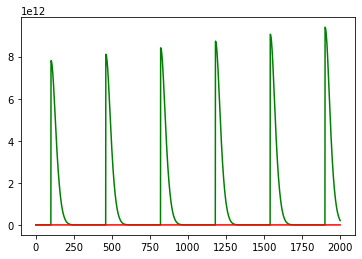

In [129]:
plt.plot(bg3[0][3323160//2-1000:3323160//2+1000],color = "green")
plt.plot(reference[3323160//2-1000:3323160//2+1000],color = "red")
plt.show()

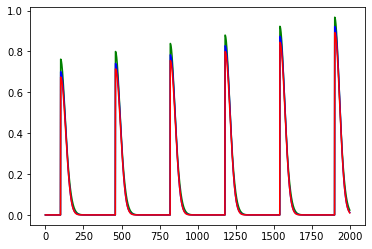

In [130]:
plt.plot(bg1[0][3323160//2-1000:3323160//2+1000],color = "green")
plt.plot(bg2[0][3323160//2-1000:3323160//2+1000],color = "blue")
plt.plot(reference[3323160//2-1000:3323160//2+1000],color = "red")
plt.show()

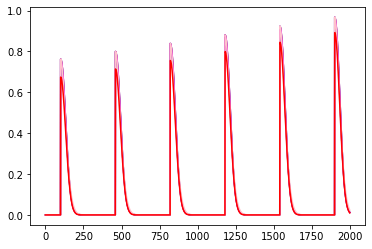

In [131]:
plt.plot(bg221[0][3323160//2-1000:3323160//2+1000],color = "black")
plt.plot(bg121[0][3323160//2-1000:3323160//2+1000],color = "magenta")
plt.plot(bg211[0][3323160//2-1000:3323160//2+1000],color = "pink")
plt.plot(reference[3323160//2-1000:3323160//2+1000],color = "red")

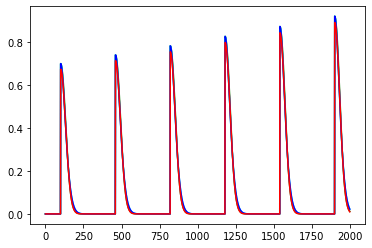

In [132]:
plt.plot(bg122[0][3323160//2-1000:3323160//2+1000],color = "green")
plt.plot(bg112[0][3323160//2-1000:3323160//2+1000],color = "cyan")
plt.plot(bg212[0][3323160//2-1000:3323160//2+1000],color = "blue")
plt.plot(reference[3323160//2-1000:3323160//2+1000],color = "red")

In [133]:
print(np.argmax(bg1[0]),np.argmax(bg2[0]),np.argmax(bg112[0]),np.argmax(bg121[0]),np.argmax(bg122[0]),np.argmax(bg211[0]),np.argmax(bg212[0]),np.argmax(bg221[0]),np.argmax(reference))

3322800 3322800 3322800 3322800 3322800 3322800 3322800 3322800 3322800


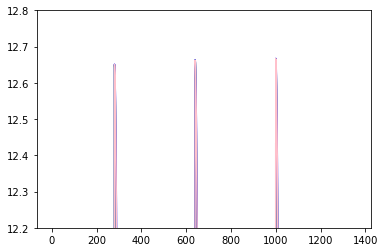

In [134]:
#plt.plot(bgmix[0][3323160-1000:3323160+1000],color = "cyan")
plt.plot(bg1[0][3322800-1000:3322800+1000],color = "green")
plt.plot(bg2[0][3322800-1000:3322800+1000],color = "blue")
#plt.plot(bgmix2[0][3323160-1000:3323160+1000],color = "magenta")
plt.plot(reference[3322800-1000:3322800+1000],color = "pink")
plt.ylim(12.2,12.8)
plt.show()

In [135]:
def table_cube(table):
    bc = np.reshape(table, (51,181,360))
    return bc

In [136]:
bc1 = table_cube(bg1[0])
bc2 = table_cube(bg2[0])
bc112 = table_cube(bg112[0])
bc121 = table_cube(bg121[0])
bc122 = table_cube(bg122[0])
bc211 = table_cube(bg211[0])
bc212 = table_cube(bg212[0])
bc221 = table_cube(bg221[0])

In [137]:
wdbc1 = abs(bc1-reference_cube)
wdbc2 = abs(bc2-reference_cube)
wdbc112 = abs(bc112-reference_cube)
wdbc121 = abs(bc121-reference_cube)
wdbc122 = abs(bc122-reference_cube)
wdbc211 = abs(bc211-reference_cube)
wdbc212 = abs(bc212-reference_cube)
wdbc221 = abs(bc221-reference_cube)

In [138]:
dbc1 = percentage(bc1,reference_cube)
dbc2 = percentage(bc2,reference_cube)
dbc112 = percentage(bc112,reference_cube)
dbc121 = percentage(bc121,reference_cube)
dbc122 = percentage(bc122,reference_cube)
dbc211 = percentage(bc211,reference_cube)
dbc212 = percentage(bc212,reference_cube)
dbc221 = percentage(bc221,reference_cube)

In [139]:
dbc1[50][180][359]

7795572620.608882

In [140]:
reference_cube[50][180][359]

2.533466036492881e-25

In [141]:
def approx_eq(x, y, tolerance=1e-4):
    return abs(x - y) < tolerance

In [142]:
def max_dif(cube):
    lst = []
    for i in range(51):
        lst.append(np.max(cube[i]))
    return lst

In [143]:
def average(cube):
    lst = []
    for i in range(51):
        lst.append(np.average(cube[i]))
    return lst

In [144]:
md1 = max_dif(dbc1)
md2 = max_dif(dbc2)
md112 = max_dif(dbc112)
md121 = max_dif(dbc121)
md122 = max_dif(dbc122)
md211 = max_dif(dbc211)
md212 = max_dif(dbc212)
md221 = max_dif(dbc221)

In [145]:
wmd1 = max_dif(wdbc1)
wmd2 = max_dif(wdbc2)
wmd112 = max_dif(wdbc112)
wmd121 = max_dif(wdbc121)
wmd122 = max_dif(wdbc122)
wmd211 = max_dif(wdbc211)
wmd212 = max_dif(wdbc212)
wmd221 = max_dif(wdbc221)

In [146]:
ad1 = average(dbc1)
ad2 = average(dbc2)
ad112 = average(dbc112)
ad121 = average(dbc121)
ad122 = average(dbc122)
ad211 = average(dbc211)
ad212 = average(dbc212)
ad221 = average(dbc221)

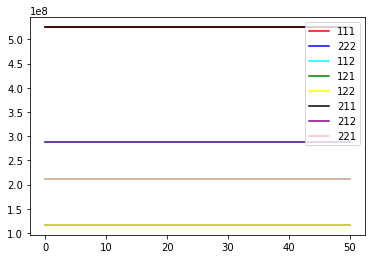

In [147]:
plt.plot(ad1, color = "red", label = "111")
plt.plot(ad2, color = "blue", label = "222")
plt.plot(ad112, color = "cyan", label = "112")
plt.plot(ad121, color = "green", label = "121")
plt.plot(ad122, color = "yellow", label = "122")
plt.plot(ad211, color = "black", label = "211")
plt.plot(ad212, color = "purple", label = "212")
plt.plot(ad221, color = "pink", label = "221")
plt.legend()
plt.show()

[]

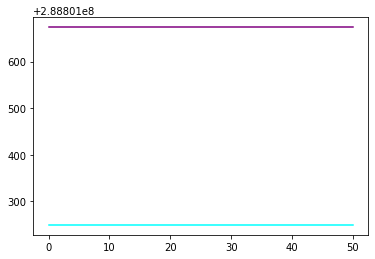

In [148]:
plt.plot(ad212, color = "purple")
plt.plot(ad112, color = "cyan")
plt.plot()

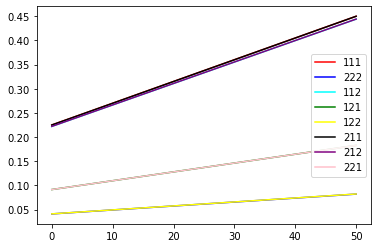

In [153]:
plt.plot(wmd1, color = "red", label = "111")
plt.plot(wmd2, color = "blue", label = "222")
plt.plot(wmd112, color = "cyan", label = "112")
plt.plot(wmd121, color = "green", label = "121")
plt.plot(wmd122, color = "yellow", label = "122")
plt.plot(wmd211, color = "black", label = "211")
plt.plot(wmd212, color = "purple", label = "212")
plt.plot(wmd221, color = "pink", label = "221")
plt.legend()
plt.show()

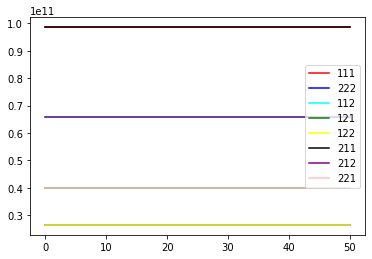

In [154]:
plt.plot(md1, color = "red", label = "111")
plt.plot(md2, color = "blue", label = "222")
plt.plot(md112, color = "cyan", label = "112")
plt.plot(md121, color = "green", label = "121")
plt.plot(md122, color = "yellow", label = "122")
plt.plot(md211, color = "black", label = "211")
plt.plot(md212, color = "purple", label = "212")
plt.plot(md221, color = "pink", label = "221")
plt.legend()
plt.show()

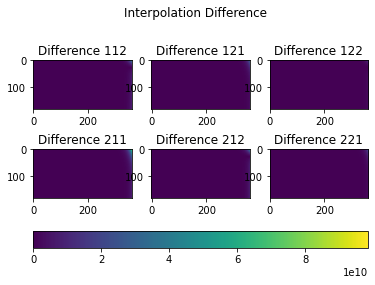

In [156]:
Nr = 2
Nc = 3
fig, axis = plt.subplots(Nr, Nc)
fig.suptitle('Interpolation Difference')
images = []
images.append(axis[0, 0].imshow(dbc112[25]))
axis[0, 0].set_title("Difference 112")
images.append(axis[0, 1].imshow(dbc121[25]))
axis[0, 1].set_title("Difference 121")
images.append(axis[0, 2].imshow(dbc122[25]))
axis[0, 2].set_title("Difference 122")
images.append(axis[1, 0].imshow(dbc211[25]))
axis[1, 0].set_title("Difference 211")
images.append(axis[1, 1].imshow(dbc212[25]))
axis[1, 1].set_title("Difference 212")
images.append(axis[1, 2].imshow(dbc221[25]))
axis[1, 2].set_title("Difference 221")
vmin = min(image.get_array().min() for image in images)
vmax = max(image.get_array().max() for image in images)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
for im in images:
    im.set_norm(norm)
fig.colorbar(images[0], ax=axis, orientation='horizontal', fraction=.1)
plt.show()

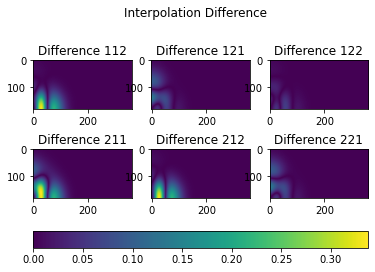

In [157]:
Nr = 2
Nc = 3
fig, axis = plt.subplots(Nr, Nc)
fig.suptitle('Interpolation Difference')
images = []
images.append(axis[0, 0].imshow(wdbc112[25]))
axis[0, 0].set_title("Difference 112")
images.append(axis[0, 1].imshow(wdbc121[25]))
axis[0, 1].set_title("Difference 121")
images.append(axis[0, 2].imshow(wdbc122[25]))
axis[0, 2].set_title("Difference 122")
images.append(axis[1, 0].imshow(wdbc211[25]))
axis[1, 0].set_title("Difference 211")
images.append(axis[1, 1].imshow(wdbc212[25]))
axis[1, 1].set_title("Difference 212")
images.append(axis[1, 2].imshow(wdbc221[25]))
axis[1, 2].set_title("Difference 221")
vmin = min(image.get_array().min() for image in images)
vmax = max(image.get_array().max() for image in images)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
for im in images:
    im.set_norm(norm)
fig.colorbar(images[0], ax=axis, orientation='horizontal', fraction=.1)
plt.show()

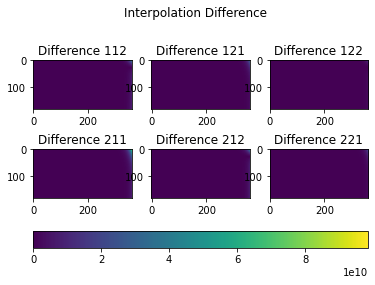

In [159]:
Nr = 2
Nc = 3
fig, axis = plt.subplots(Nr, Nc)
fig.suptitle('Interpolation Difference')
images = []
images.append(axis[0, 0].imshow(dbc112[50]))
axis[0, 0].set_title("Difference 112")
images.append(axis[0, 1].imshow(dbc121[50]))
axis[0, 1].set_title("Difference 121")
images.append(axis[0, 2].imshow(dbc122[50]))
axis[0, 2].set_title("Difference 122")
images.append(axis[1, 0].imshow(dbc211[50]))
axis[1, 0].set_title("Difference 211")
images.append(axis[1, 1].imshow(dbc212[50]))
axis[1, 1].set_title("Difference 212")
images.append(axis[1, 2].imshow(dbc221[50]))
axis[1, 2].set_title("Difference 221")
vmin = min(image.get_array().min() for image in images)
vmax = max(image.get_array().max() for image in images)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
for im in images:
    im.set_norm(norm)
fig.colorbar(images[0], ax=axis, orientation='horizontal', fraction=.1)
plt.show()

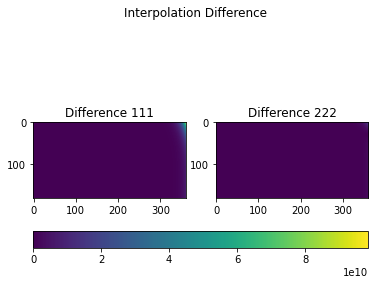

In [160]:
Nr = 1
Nc = 2
fig, axis = plt.subplots(Nr, Nc)
fig.suptitle('Interpolation Difference')
images = []
images.append(axis[0].imshow(dbc1[25]))
axis[0].set_title("Difference 111")
images.append(axis[1].imshow(dbc2[25]))
axis[1].set_title("Difference 222")
vmin = min(image.get_array().min() for image in images)
vmax = max(image.get_array().max() for image in images)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
for im in images:
    im.set_norm(norm)
fig.colorbar(images[0], ax=axis, orientation='horizontal', fraction=.1)
plt.show()

In [161]:
#Difference Cube's mean function
def mean_map(cube):
    lst = []
    for i in range(51):
        lst.append(np.mean(cube[i]))
    return lst

In [162]:
#Difference Cube's median function
def med_map(cube):
    lst = []
    for i in range(51):
        lst.append(np.median(cube[i]))
    return lst

In [163]:
meanwdbc111 = mean_map(wdbc1)
meanwdbc222 = mean_map(wdbc2)
meanwdbc112 = mean_map(wdbc112)
meanwdbc121 = mean_map(wdbc121)
meanwdbc122 = mean_map(wdbc122)
meanwdbc211 = mean_map(wdbc211)
meanwdbc212 = mean_map(wdbc212)
meanwdbc221 = mean_map(wdbc221)

In [164]:
medwdbc111 = med_map(wdbc1)
medwdbc222 = med_map(wdbc2)
medwdbc112 = med_map(wdbc112)
medwdbc121 = med_map(wdbc121)
medwdbc122 = med_map(wdbc122)
medwdbc211 = med_map(wdbc211)
medwdbc212 = med_map(wdbc212)
medwdbc221 = med_map(wdbc221)

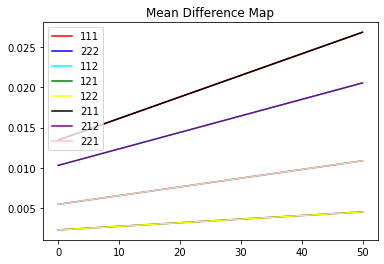

In [165]:
# Mean difference Map
plt.title("Mean Difference Map")
plt.plot(meanwdbc111, color = "red", label = "111")
plt.plot(meanwdbc222, color = "blue", label = "222")
plt.plot(meanwdbc112, color = "cyan", label = "112")
plt.plot(meanwdbc121, color = "green", label = "121")
plt.plot(meanwdbc122, color = "yellow", label = "122")
plt.plot(meanwdbc211, color = "black", label = "211")
plt.plot(meanwdbc212, color = "purple", label = "212")
plt.plot(meanwdbc221, color = "pink", label = "221")
plt.legend()
plt.show()

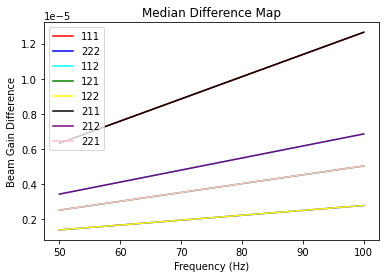

In [207]:
# Median Difference Map
plt.title("Median Difference Map")
plt.plot(freq, medwdbc111, color = "red", label = "111")
plt.plot(freq, medwdbc222, color = "blue", label = "222")
plt.plot(freq, medwdbc112, color = "cyan", label = "112")
plt.plot(freq, medwdbc121, color = "green", label = "121")
plt.plot(freq, medwdbc122, color = "yellow", label = "122")
plt.plot(freq, medwdbc211, color = "black", label = "211")
plt.plot(freq, medwdbc212, color = "purple", label = "212")
plt.plot(freq, medwdbc221, color = "pink", label = "221")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Beam Gain Difference")
plt.legend()
plt.show()

In [167]:
meandbc111 = mean_map(dbc1)
meandbc222 = mean_map(dbc2)
meandbc112 = mean_map(dbc112)
meandbc121 = mean_map(dbc121)
meandbc122 = mean_map(dbc122)
meandbc211 = mean_map(dbc211)
meandbc212 = mean_map(dbc212)
meandbc221 = mean_map(dbc221)

In [168]:
meddbc111 = med_map(dbc1)
meddbc222 = med_map(dbc2)
meddbc112 = med_map(dbc112)
meddbc121 = med_map(dbc121)
meddbc122 = med_map(dbc122)
meddbc211 = med_map(dbc211)
meddbc212 = med_map(dbc212)
meddbc221 = med_map(dbc221)

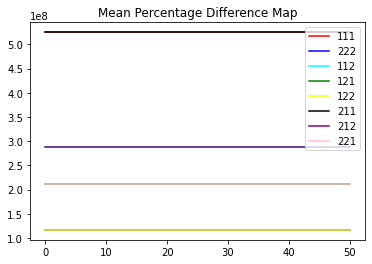

In [170]:
# Mean Percentage difference Map
plt.title("Mean Percentage Difference Map")
plt.plot(meandbc111, color = "red", label = "111")
plt.plot(meandbc222, color = "blue", label = "222")
plt.plot(meandbc112, color = "cyan", label = "112")
plt.plot(meandbc121, color = "green", label = "121")
plt.plot(meandbc122, color = "yellow", label = "122")
plt.plot(meandbc211, color = "black", label = "211")
plt.plot(meandbc212, color = "purple", label = "212")
plt.plot(meandbc221, color = "pink", label = "221")
plt.legend()
plt.show()

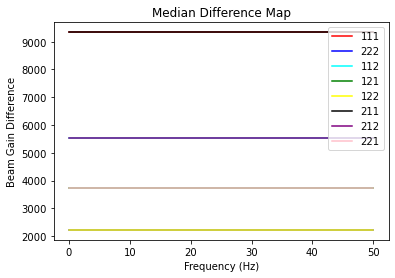

In [171]:
# Median Percentage Difference Map
plt.title("Median Difference Map")
plt.plot(meddbc111, color = "red", label = "111")
plt.plot(meddbc222, color = "blue", label = "222")
plt.plot(meddbc112, color = "cyan", label = "112")
plt.plot(meddbc121, color = "green", label = "121")
plt.plot(meddbc122, color = "yellow", label = "122")
plt.plot(meddbc211, color = "black", label = "211")
plt.plot(meddbc212, color = "purple", label = "212")
plt.plot(meddbc221, color = "pink", label = "221")
plt.xlabel("Frequency (Hz)")

plt.ylabel("Beam Gain Difference")
plt.legend()
plt.show()

(array([3.284757e+06, 2.116500e+04, 7.701000e+03, 4.029000e+03,
        2.244000e+03, 1.377000e+03, 9.180000e+02, 5.100000e+02,
        2.550000e+02, 2.040000e+02]),
 array([7.56864003e-10, 9.85376574e+09, 1.97075315e+10, 2.95612972e+10,
        3.94150630e+10, 4.92688287e+10, 5.91225945e+10, 6.89763602e+10,
        7.88301259e+10, 8.86838917e+10, 9.85376574e+10]),
 <BarContainer object of 10 artists>)

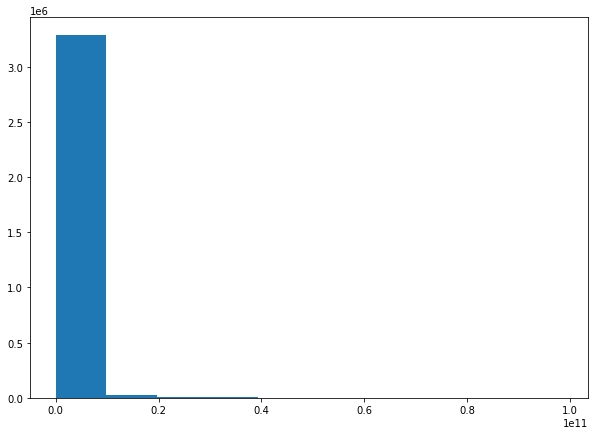

In [172]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(dbc1.flatten())

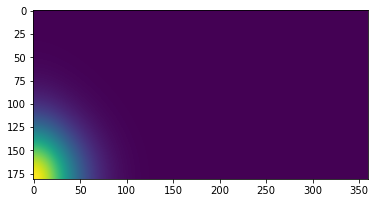

In [204]:
plt.imshow(bc1[0])

(array([2.907677e+06, 1.698310e+05, 8.652000e+04, 5.722500e+04,
        3.940400e+04, 2.670400e+04, 1.569600e+04, 1.062800e+04,
        6.693000e+03, 2.782000e+03]),
 array([5.00098665e-21, 4.49994857e-02, 8.99989713e-02, 1.34998457e-01,
        1.79997943e-01, 2.24997428e-01, 2.69996914e-01, 3.14996400e-01,
        3.59995885e-01, 4.04995371e-01, 4.49994857e-01]),
 <BarContainer object of 10 artists>)

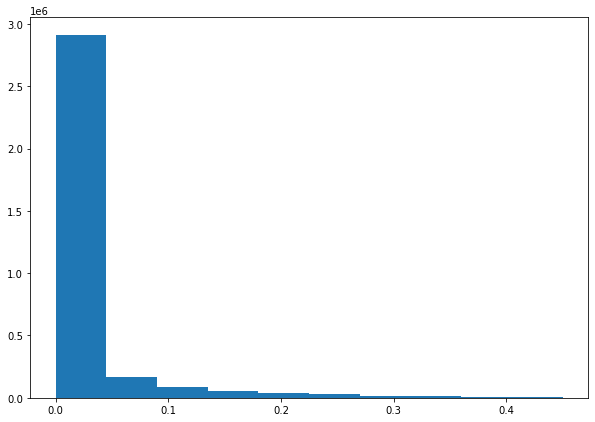

In [173]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(wdbc1.flatten())

In [198]:
# Cutting +- 45 Degree cube
cdbc111 = dbc1[:,0:45,:]
cdbc112 = dbc112[:,0:45,:]
cdbc121 = dbc121[:,0:45,:]
cdbc122 = dbc122[:,0:45,:]
cdbc211 = dbc211[:,0:45,:]
cdbc212 = dbc212[:,0:45,:]
cdbc221 = dbc221[:,0:45,:]
cdbc222 = dbc2[:,0:45,:]

In [199]:
meancdbc111 = mean_map(cdbc111)
meancdbc222 = mean_map(cdbc222)
meancdbc112 = mean_map(cdbc112)
meancdbc121 = mean_map(cdbc121)
meancdbc122 = mean_map(cdbc122)
meancdbc211 = mean_map(cdbc211)
meancdbc212 = mean_map(cdbc212)
meancdbc221 = mean_map(cdbc221)

medcdbc111 = med_map(cdbc111)
medcdbc222 = med_map(cdbc222)
medcdbc112 = med_map(cdbc112)
medcdbc121 = med_map(cdbc121)
medcdbc122 = med_map(cdbc122)
medcdbc211 = med_map(cdbc211)
medcdbc212 = med_map(cdbc212)
medcdbc221 = med_map(cdbc221)

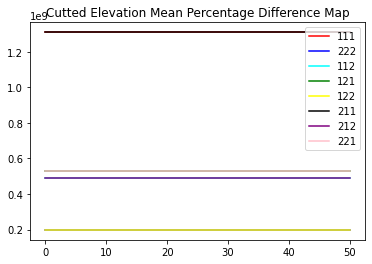

In [200]:
# Cutted Mean Percentage difference Map
plt.title("Cutted Elevation Mean Percentage Difference Map")
plt.plot(meancdbc111, color = "red", label = "111")
plt.plot(meancdbc222, color = "blue", label = "222")
plt.plot(meancdbc112, color = "cyan", label = "112")
plt.plot(meancdbc121, color = "green", label = "121")
plt.plot(meancdbc122, color = "yellow", label = "122")
plt.plot(meancdbc211, color = "black", label = "211")
plt.plot(meancdbc212, color = "purple", label = "212")
plt.plot(meancdbc221, color = "pink", label = "221")
plt.legend()
plt.show()

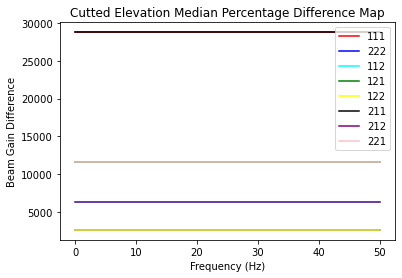

In [202]:
# Cutted Median Percentage Difference Map
plt.title("Cutted Elevation Median Percentage Difference Map")
plt.plot(medcdbc111, color = "red", label = "111")
plt.plot(medcdbc222, color = "blue", label = "222")
plt.plot(medcdbc112, color = "cyan", label = "112")
plt.plot(medcdbc121, color = "green", label = "121")
plt.plot(medcdbc122, color = "yellow", label = "122")
plt.plot(medcdbc211, color = "black", label = "211")
plt.plot(medcdbc212, color = "purple", label = "212")
plt.plot(medcdbc221, color = "pink", label = "221")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Beam Gain Difference")
plt.legend()
plt.show()